# Computational Genomics - Project 2
# Authors: Kacper Grzymkowski, Mikołaj Malec, Piotr Marciniak

The goal of the project is to create an algorithm that will identify topologically associating domains (TADs) on the basis of the heatmap from the Hi-C experiment.
We will compare the results of our algorithm with the established method Arrowhead.

# Data downloading

In [1]:
!mkdir data
!wget "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM1551688&format=file&file=GSM1551688%5FHIC143%2Ehic" -O data/GM12878.hic
!wget https://pages.mini.pw.edu.pl/~chilinskim/GO_files/inter_30.hic -O data/inter_30.hic
!wget "https://www.encodeproject.org/files/ENCFF629KXF/@@download/ENCFF629KXF.hic" -O data/ENCFF629KXF.hic 

mkdir: cannot create directory ‘data’: File exists
--2024-04-07 15:01:04--  https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM1551688&format=file&file=GSM1551688%5FHIC143%2Ehic
Resolving www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)... 130.14.29.110, 2607:f220:41e:4290::110
Connecting to www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)|130.14.29.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 486456054 (464M) [application/octet-stream]
Saving to: ‘data/GM12878.hic’

data/GM12878.hic    100%[===================>] 463.92M  8.34MB/s    in 2m 17s  

2024-04-07 15:03:22 (3.38 MB/s) - ‘data/GM12878.hic’ saved [486456054/486456054]

--2024-04-07 15:03:22--  https://pages.mini.pw.edu.pl/~chilinskim/GO_files/inter_30.hic
Resolving pages.mini.pw.edu.pl (pages.mini.pw.edu.pl)... 194.29.178.29
Connecting to pages.mini.pw.edu.pl (pages.mini.pw.edu.pl)|194.29.178.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4218033561 (3.9G)
Saving to: ‘data/int

The hic file present on the page https://data.4dnucleome.org/experiment-set-replicates/4DNES3JX38V5/ should be downloaded manually due to needed authorization.

[Exact download location](https://data.4dnucleome.org/files-processed/4DNFI1UEG1HD/@@download/4DNFI1UEG1HD.hic).

# Packages import

In [1]:
import hicstraw
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Load data
The data is loaded from the `data` directory, which contains files
* `GM12878.hic` 
* `inter_30.hic` 
* `ENCFF629KXF.hic` 
* `4DNFI1UEG1HD.hic`

## GM12878

In [2]:
gm_hic = hicstraw.HiCFile("data/GM12878.hic")
gm_hic.getGenomeID(), gm_hic.getResolutions()

('hg19', [2500000, 1000000, 500000, 250000, 100000, 50000, 25000, 10000, 5000])

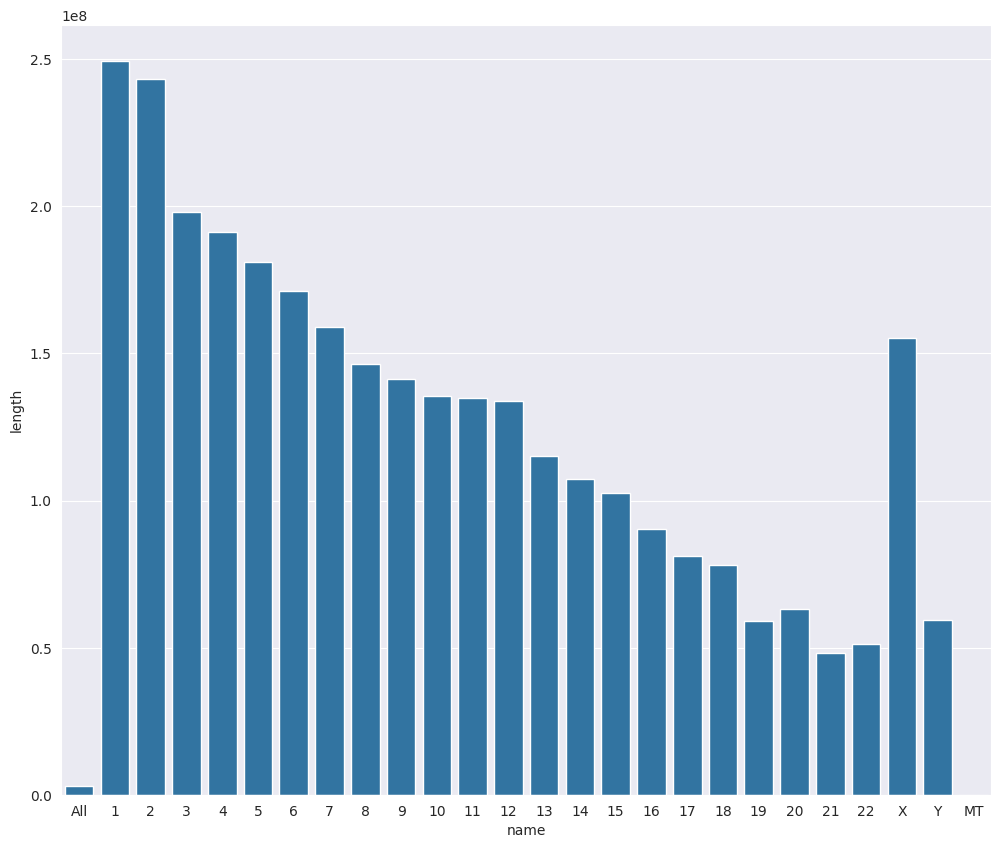

In [3]:
gm_lengths = pd.DataFrame([(chromosome.name, chromosome.length) for chromosome in gm_hic.getChromosomes()], columns=["name", "length"])
plt.figure(figsize=(12, 10))
sns.barplot(gm_lengths, x="name", y="length")
plt.show()

## inter_30

In [4]:
inter_30 = hicstraw.HiCFile("data/inter_30.hic")
inter_30.getGenomeID(), inter_30.getResolutions()

('/mnt/raid/juicer/misc/hg38_chrom.sizes',
 [2500000, 1000000, 500000, 250000, 100000, 50000, 25000, 10000, 5000])

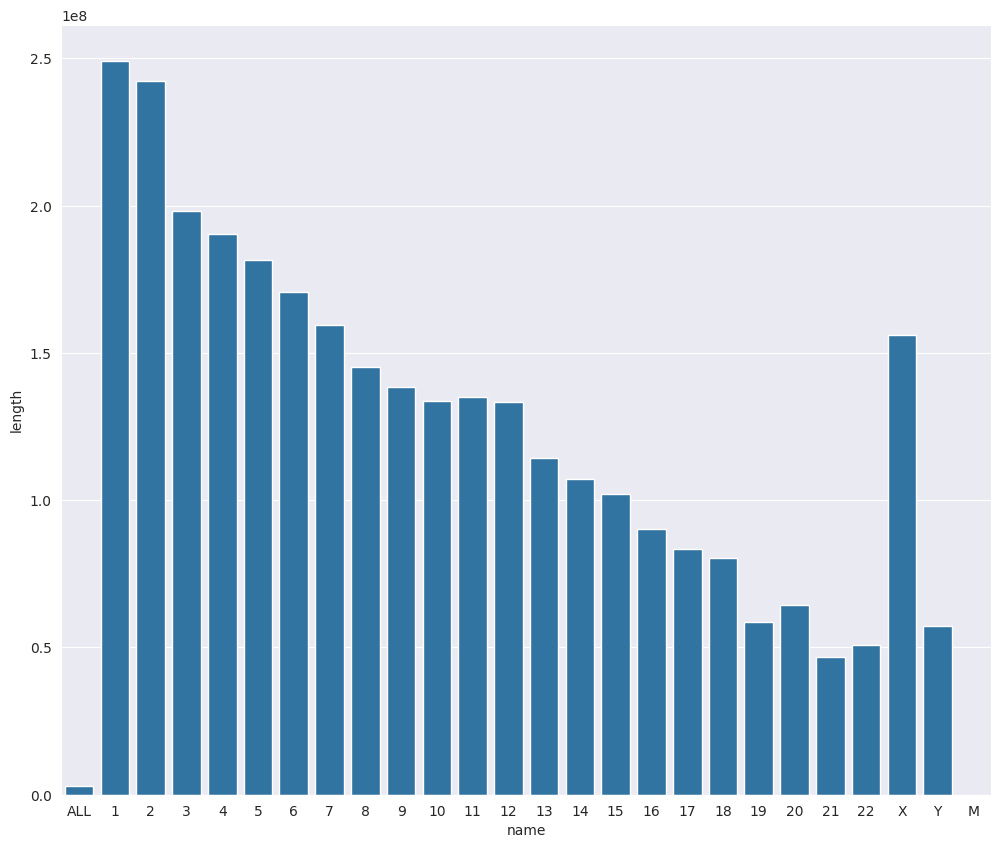

In [5]:
inter_lengths = pd.DataFrame([(chromosome.name, chromosome.length) for chromosome in inter_30.getChromosomes()], columns=["name", "length"])
plt.figure(figsize=(12, 10))
sns.barplot(inter_lengths, x="name", y="length")
plt.show()

## ENCFF629KXF

In [6]:
enc = hicstraw.HiCFile("data/ENCFF629KXF.hic")
enc.getGenomeID(), enc.getResolutions()

('/projects/ruan-lab/processing/genomes/hg38/hg38.chrom.sizes',
 [2500000, 1000000, 500000, 250000, 100000, 50000, 25000, 10000, 5000, 1000])

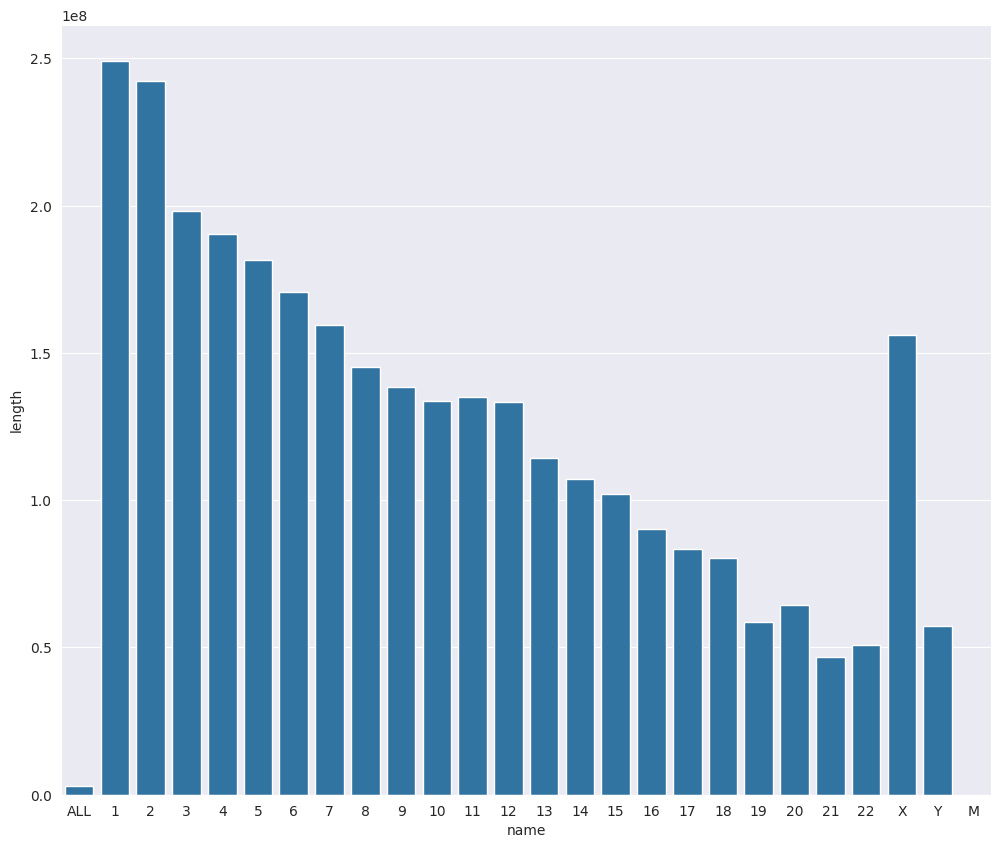

In [7]:
enc_lengths = pd.DataFrame([(chromosome.name, chromosome.length) for chromosome in enc.getChromosomes()], columns=["name", "length"])
plt.figure(figsize=(12, 10))
sns.barplot(enc_lengths, x="name", y="length")
plt.show()

## 4DNFI1UEG1HD

In [8]:
dnf_hic = hicstraw.HiCFile("data/4DNFI1UEG1HD.hic")
dnf_hic.getGenomeID(), dnf_hic.getResolutions()

('/var/lib/cwl/stgaf4b8b89-d7e9-4c14-8683-d22fc778af87/4DNFI823LSII.chrom.sizes',
 [10000000,
  5000000,
  2500000,
  1000000,
  500000,
  250000,
  100000,
  50000,
  25000,
  10000,
  5000,
  2000,
  1000])

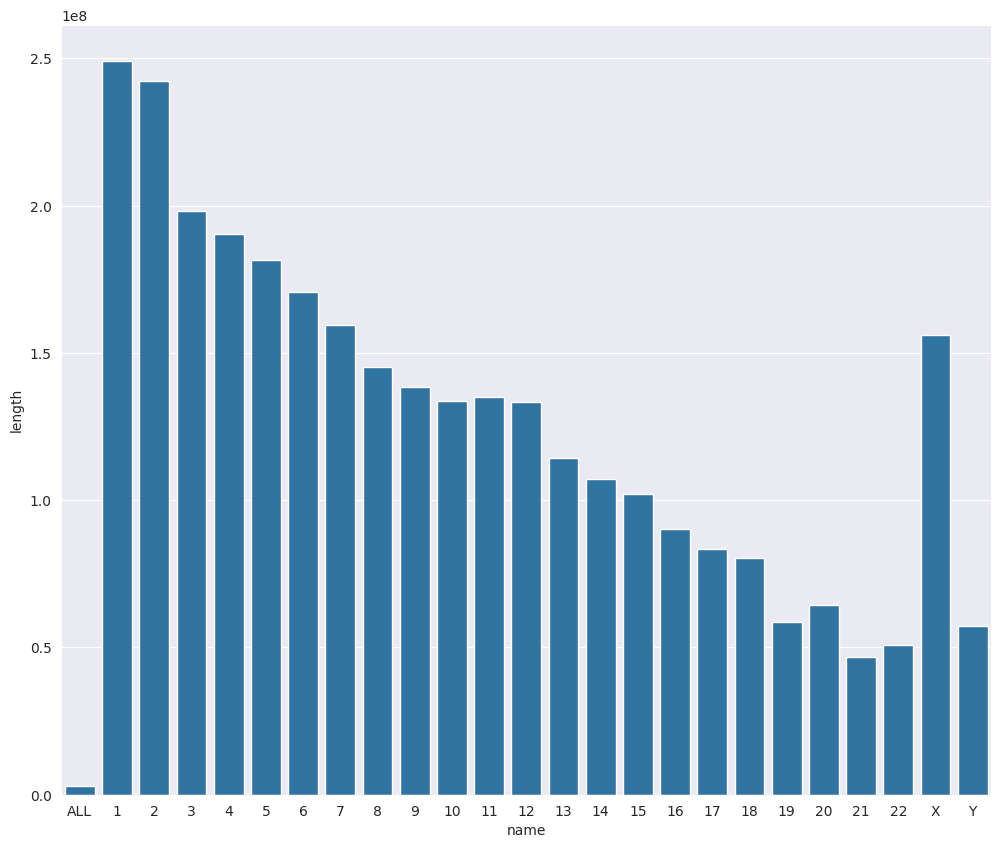

In [9]:
dnf_lengths = pd.DataFrame([(chromosome.name, chromosome.length) for chromosome in dnf_hic.getChromosomes()], columns=["name", "length"])
plt.figure(figsize=(12, 10))
sns.barplot(dnf_lengths, x="name", y="length")
plt.show()

# Arrowhead
Arrowhead has five optional arguments presented in the list below (description from [Arrowhead documentation](https://github.com/aidenlab/juicer/wiki/Arrowhead)).
    
   * `-c <String(s)>` Chromosome(s) on which Arrowhead will be run. The number/letter for the chromosome can be used with or without appending the "chr" string. Multiple chromosomes can be specified using commas (e.g. 1,chr2,X,chrY)
   * `-m <int>` Size of the sliding window along the diagonal in which contact domains will be found. Must be an even number as (m/2) is used as the increment for the sliding window. (Default 2000)
   * `-r <int>` resolution for which Arrowhead will be run. Generally, 5kB (5000) or 10kB (10000) resolution is used depending on the depth of sequencing in the HiC file(s).
   * `-k <NONE/VC/VC_SQRT/KR>` Normalizations (case sensitive) that can be selected. Generally, KR (Knight-Ruiz) balancing should be used when available.
   * `--threads <int>` Number of threads to use (Arrowhead is multi-threaded). As of Juicer Tools Version 1.13.02, the default number of threads used is 1. Passing in a value of 0 will result in the jar calculating the number of available threads. Passing in a value >0 will result in that value being used directly.

## Setting up Arrowhead

In [10]:
!wget https://s3.amazonaws.com/hicfiles.tc4ga.com/public/juicer/juicer_tools_1.22.01.jar -O juicer_tools_1.22.01.jar

--2024-04-07 17:18:55--  https://s3.amazonaws.com/hicfiles.tc4ga.com/public/juicer/juicer_tools_1.22.01.jar
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.229.160, 52.217.196.8, 52.217.69.134, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.229.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36188666 (35M) [application/x-www-form-urlencoded]
Saving to: ‘juicer_tools_1.22.01.jar’

juicer_tools_1.22.0 100%[===================>]  34.51M  15.6MB/s    in 2.2s    

2024-04-07 17:18:58 (15.6 MB/s) - ‘juicer_tools_1.22.01.jar’ saved [36188666/36188666]



In [11]:
# Java Version 8 or higher is needed to run Arrowhead
# !sudo apt install openjdk-11-jre
!mkdir results

mkdir: cannot create directory ‘results’: File exists


## Running commands

In [14]:
!wc -l data/GM12878.hic

1323784 data/GM12878.hic


In [12]:
!wc -l data/ENCFF629KXF.hic

1974289 data/ENCFF629KXF.hic


In [13]:
!wc -l data/inter_30.hic

9894886 data/inter_30.hic


In [15]:
!wc -l data/4DNFI1UEG1HD.hic

53237917 data/4DNFI1UEG1HD.hic


In [20]:
# -Xmx10g sets 10GB of RAM (standard instance)
!java -Xmx20g -jar juicer_tools_1.22.01.jar arrowhead data/GM12878.hic results/gm12878 --threads 16 -r 5000 -k KR --ignore-sparsity

WARN [2024-04-07T17:40:22,510]  [Globals.java:138] [main]  Development mode is enabled
Reading file: data/GM12878.hic
Using 16 CPU thread(s)
max 25.0
4% 
8% 
12% 
16% 
20% 
24% 
28% 
32% 
36% 
40% 
44% 
48% 
52% 
56% 
60% 
64% 
68% 
72% 
76% 
80% 
84% 
88% 
92% 
96% 
100% 
0 domains written to file: /home/cinek/Computional Genomics/Project 2/Solution/results/gm12878/5000_blocks.bedpe
Arrowhead complete


In [21]:
!java -Xmx20g -jar juicer_tools_1.22.01.jar arrowhead data/inter_30.hic results/inter_30 --threads 16 -r 5000 -k KR --ignore-sparsity

WARN [2024-04-07T17:58:21,853]  [Globals.java:138] [main]  Development mode is enabled
Reading file: data/inter_30.hic
Using 16 CPU thread(s)
max 25.0
4% 
8% 
12% 
16% 
20% 
24% 
28% 
32% 
36% 
40% 
44% 
48% 
52% 
56% 
60% 
64% 
68% 
72% 
76% 
80% 
84% 
88% 
92% 
96% 
100% 
6 features written to file: /home/cinek/Computional Genomics/Project 2/Solution/results/inter_30/5000_blocks.bedpe
6 domains written to file: /home/cinek/Computional Genomics/Project 2/Solution/results/inter_30/5000_blocks.bedpe
Arrowhead complete


In [24]:
!java -Xmx20g -jar juicer_tools_1.22.01.jar arrowhead data/ENCFF629KXF.hic results/ENCFF629KXF --threads 16 -r 5000 -k KR --ignore-sparsity

WARN [2024-04-07T18:12:31,728]  [Globals.java:138] [main]  Development mode is enabled
Reading file: data/ENCFF629KXF.hic
Using 16 CPU thread(s)
max 25.0
4% 
8% 
12% 
16% 
20% 
24% 
28% 
32% 
36% 
40% 
44% 
48% 
52% 
56% 
60% 
64% 
68% 
72% 
76% 
80% 
84% 
88% 
92% 
96% 
100% 
0 domains written to file: /home/cinek/Computional Genomics/Project 2/Solution/results/ENCFF629KXF/5000_blocks.bedpe
Arrowhead complete


In [25]:
!java -Xmx20g -jar juicer_tools_1.22.01.jar arrowhead data/4DNFI1UEG1HD.hic results/4DNFI1UEG1HD --threads 16 -r 5000 -k KR

WARN [2024-04-07T18:20:24,237]  [Globals.java:138] [main]  Development mode is enabled
Reading file: data/4DNFI1UEG1HD.hic
Using 16 CPU thread(s)
max 24.0
4% 
8% 
12% 
16% 
20% 
25% 
29% 
33% 
37% 
41% 
45% 
50% 
54% 
58% 
62% 
66% 
70% 
75% 
79% 
83% 
87% 
91% 
95% 
100% 
9685 features written to file: /home/cinek/Computional Genomics/Project 2/Solution/results/4DNFI1UEG1HD/5000_blocks.bedpe
9685 domains written to file: /home/cinek/Computional Genomics/Project 2/Solution/results/4DNFI1UEG1HD/5000_blocks.bedpe
Arrowhead complete


# Our implementation

In [26]:
# To get matrix as numpy
# Example
# hic.getMatrixZoomData(chrom1, chrom2, data_type, normalization, "BP", resolution)
# data_type: 'observed' (previous default / "main" data) or 'oe' (observed/expected)
# normalization: NONE, VC, VC_SQRT, KR, SCALE, etc.
# resolution: typically 2500000, 1000000, 500000, 100000, 50000, 25000, 10000, 5000, etc.

dnf_zoom = dnf_hic.getMatrixZoomData('11', '11', "observed", "NONE", "BP", 50000)
dnf_zoom.getRecordsAsMatrix(0, 8_000_000, 0, 8_000_000)

array([[0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [0.0000e+00, 0.0000e+00, 1.8900e+02, ..., 3.0000e+00, 0.0000e+00,
        2.0000e+00],
       ...,
       [0.0000e+00, 0.0000e+00, 3.0000e+00, ..., 7.9710e+03, 5.1120e+03,
        2.0780e+03],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 5.1120e+03, 1.5077e+04,
        6.0580e+03],
       [0.0000e+00, 0.0000e+00, 2.0000e+00, ..., 2.0780e+03, 6.0580e+03,
        1.6857e+04]])

# Running our implementation